# Titanic Survival Prediction 

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import gunicorn
import matplotlib.pyplot as plt
import seaborn as sns

### loading dataset

In [2]:
df = pd.read_csv('Titanic-Dataset.csv')
df[:10][:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### initial observation

In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### EDA

In [5]:
df['TicketGroupFareMean'] = df.groupby('Ticket')['Fare'].transform('mean')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketGroupFareMean
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,8.0500


In [6]:
df['FarePerPerson'] = df['Fare'] / df.groupby('Ticket')['Ticket'].transform('count')

In [7]:
df['TicketGroup'] = df.groupby('Ticket')['Ticket'].transform('count')

In [8]:
df.drop(['PassengerId', 'Ticket' , 'Fare' , 'TicketGroupFareMean' , 'Cabin' ], axis=1, inplace=True)

In [9]:
cat_df = df.select_dtypes(include=['object']).copy()
cat_df.head()

,Name,Sex,Embarked
0,"Braund, Mr. Owen Harris",male,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,C
2,"Heikkinen, Miss. Laina",female,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,S
4,"Allen, Mr. William Henry",male,S


In [10]:
numeric_df = df.select_dtypes(include=['number']).copy()
numeric_df.head()

,Survived,Pclass,Age,SibSp,Parch,FarePerPerson,TicketGroup
0,0,3,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,1
2,1,3,26.0,0,0,7.9250,1
3,1,1,35.0,1,0,26.5500,2
4,0,3,35.0,0,0,8.0500,1


<Axes: >

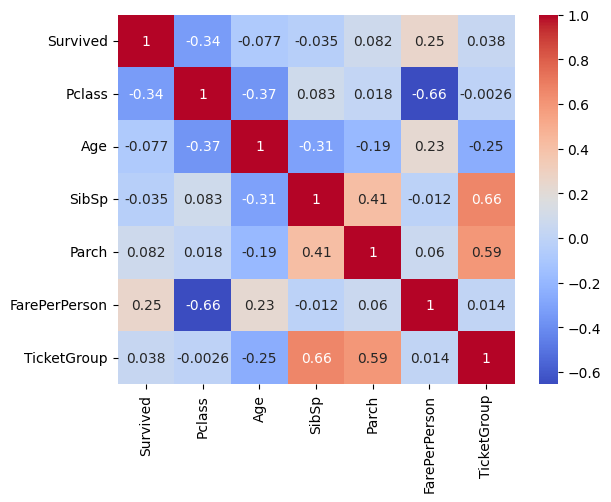

In [11]:
sns.heatmap(numeric_df.corr(), annot=True , cmap='coolwarm')

In [12]:
numeric_df.corrwith(df['Survived'])

Survived         1.000000
Pclass          -0.338481
Age             -0.077221
SibSp           -0.035322
Parch            0.081629
FarePerPerson    0.254824
TicketGroup      0.038247
dtype: float64

In [14]:
# can drop passenger - id as it has no effect on survival
# can drop name as it has no effect on survival

In [13]:
numeric_df.info()
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    int64  
 1   Pclass         891 non-null    int64  
 2   Age            714 non-null    float64
 3   SibSp          891 non-null    int64  
 4   Parch          891 non-null    int64  
 5   FarePerPerson  891 non-null    float64
 6   TicketGroup    891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      891 non-null    object
 1   Sex       891 non-null    object
 2   Embarked  889 non-null    object
dtypes: object(3)
memory usage: 21.0+ KB


In [15]:
cat_df = cat_df.drop('Name' , axis=1,)

In [16]:
cat_df.head()

,Sex,Embarked
0,male,S
1,female,C
2,female,S
3,female,S
4,male,S


In [17]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_cat = encoder.fit_transform(cat_df)
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(cat_df.columns))
encoded_cat_df.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0


In [18]:
encoded_cat_df_w_keys = pd.concat([encoded_cat_df , df[['Survived']]], axis=1)
encoded_cat_df_w_keys.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Survived
0,0.0,1.0,0.0,0.0,1.0,0.0,0
1,1.0,0.0,1.0,0.0,0.0,0.0,1
2,1.0,0.0,0.0,0.0,1.0,0.0,1
3,1.0,0.0,0.0,0.0,1.0,0.0,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0


In [19]:
encoded_cat_df_w_keys.corrwith(encoded_cat_df_w_keys['Survived'])

Sex_female      0.543351
Sex_male       -0.543351
Embarked_C      0.168240
Embarked_Q      0.003650
Embarked_S     -0.155660
Embarked_nan    0.060095
Survived        1.000000
dtype: float64

In [20]:
df_final = pd.concat([numeric_df , encoded_cat_df] , axis=1)
df_final.head()

,Survived,Pclass,Age,SibSp,Parch,FarePerPerson,TicketGroup,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0,3,22.0,1,0,7.2500,1,0.0,1.0,0.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,1,1.0,0.0,1.0,0.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1,1.0,0.0,0.0,0.0,1.0,0.0
3,1,1,35.0,1,0,26.5500,2,1.0,0.0,0.0,0.0,1.0,0.0
4,0,3,35.0,0,0,8.0500,1,0.0,1.0,0.0,0.0,1.0,0.0


In [43]:
df_final.isna().sum()

Survived           0
Pclass             0
Age              177
SibSp              0
Parch              0
FarePerPerson      0
TicketGroup        0
Sex_female         0
Sex_male           0
Embarked_C         0
Embarked_Q         0
Embarked_S         0
Embarked_nan       0
dtype: int64

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score , KFold
from sklearn.svm import SVC


In [37]:
x_data = df_final.drop('Survived' , axis=1)
y_data = df_final['Survived']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((712, 12), (179, 12), (712,), (179,))

In [45]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

In [48]:
scalingPipeline = Pipeline([
    ('scaler' , StandardScaler())])
scaled_x_train = scalingPipeline.fit_transform(x_train)

In [49]:
pipe = []
pipe.append((('xgb' , XGBClassifier())))
pipe.append((('rf' , RandomForestClassifier())))
pipe.append((('lgr' , LogisticRegression())))
pipe.append((('SVC' , SVC())))


In [52]:
model_name = []
results = []

for name, model in pipe:
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, scaled_x_train, y_train, cv=kf, scoring='accuracy')
    model_name.append(name)
    results.append(cv_results)
    print(f"{name} : {cv_results.mean()*100}% +/- {cv_results.std()*100}%")

xgb : 78.79890453834115% +/- 4.4755518306091995%
rf : 78.79499217527386% +/- 5.54149320121669%
lgr : 79.91392801251956% +/- 3.6774631204960078%
SVC : 80.8998435054773% +/- 3.3899130307167167%


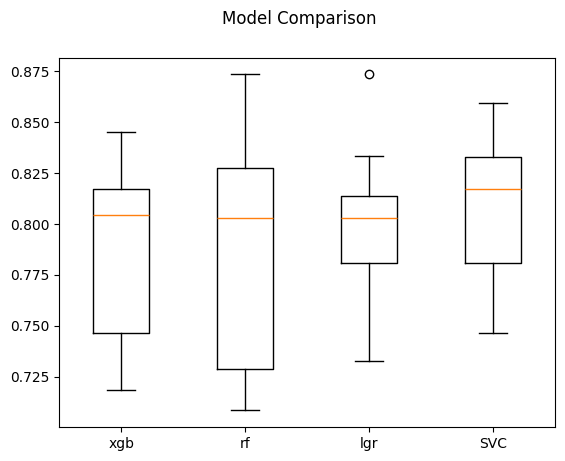

In [54]:
fig = plt.figure()
fig.suptitle("Model Comparison")
ax = fig.add_subplot(111)
ax.boxplot(results)
ax.set_xticklabels(model_name)
plt.show()